In [3]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from datetime import datetime

import sys
sys.path.insert(0, "PPO_agents")

from PPO import PPO
from PPO_MINI import PPO as PPO_MINI
from PPO_MINI_GAE import PPO as PPO_MINI_GAE
from PPO_GAE import PPO as PPO_GAE
from SAFE_PPO import PPO as PPO_SAFE

from rocket import Rocket

from tqdm.auto import tqdm
import gymnasium as gym

import pickle
import math

Device set to : NVIDIA GeForce RTX 2070 with Max-Q Design
Device set to : NVIDIA GeForce RTX 2070 with Max-Q Design
Device set to : NVIDIA GeForce RTX 2070 with Max-Q Design
Device set to : NVIDIA GeForce RTX 2070 with Max-Q Design


### Utils

In [4]:
def compare_episode_rewards(ax, rewards1, rewards2, label1="Agent 1", label2="Agent 2"):
    """
    Compare two sets of episodic rewards over training.
    and plot a linear regression trend line for each agent.
    """
    sns.set()

    # Plot raw episode rewards
    x1 = np.arange(len(rewards1))
    x2 = np.arange(len(rewards2))

    ax.plot(x1, rewards1, label=label1)
    ax.plot(x2, rewards2, label=label2)

    if len(rewards1) >= 2:
        X1 = x1.reshape(-1, 1)
        y1 = np.array(rewards1).reshape(-1, 1)
        reg1 = LinearRegression().fit(X1, y1)
        x1_pred = np.linspace(0, len(rewards1) - 1, 100).reshape(-1, 1)
        y1_pred = reg1.predict(x1_pred)
        ax.plot(x1_pred, y1_pred, "--", label=f"{label1} trend")

    if len(rewards2) >= 2:
        X2 = x2.reshape(-1, 1)
        y2 = np.array(rewards2).reshape(-1, 1)
        reg2 = LinearRegression().fit(X2, y2)
        x2_pred = np.linspace(0, len(rewards2) - 1, 100).reshape(-1, 1)
        y2_pred = reg2.predict(x2_pred)
        ax.plot(x2_pred, y2_pred, "--", label=f"{label2} trend")

    ax.set_title("Comparison of Episode Rewards")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.legend()


def compare_episode_lengths(ax, lengths1, lengths2, label1="Agent 1", label2="Agent 2"):
    """
    Compare two sets of episode lengths over training,
    and plot a linear regression trend line for each agent.
    """
    sns.set()

    x1 = np.arange(len(lengths1))
    x2 = np.arange(len(lengths2))

    ax.plot(x1, lengths1, label=label1)
    ax.plot(x2, lengths2, label=label2)

    if len(lengths1) >= 2:
        X1 = x1.reshape(-1, 1)
        y1 = np.array(lengths1).reshape(-1, 1)
        reg1 = LinearRegression().fit(X1, y1)
        x1_pred = np.linspace(0, len(lengths1) - 1, 100).reshape(-1, 1)
        y1_pred = reg1.predict(x1_pred)
        ax.plot(x1_pred, y1_pred, "--", label=f"{label1} trend")

    if len(lengths2) >= 2:
        X2 = x2.reshape(-1, 1)
        y2 = np.array(lengths2).reshape(-1, 1)
        reg2 = LinearRegression().fit(X2, y2)
        x2_pred = np.linspace(0, len(lengths2) - 1, 100).reshape(-1, 1)
        y2_pred = reg2.predict(x2_pred)
        ax.plot(x2_pred, y2_pred, "--", label=f"{label2} trend")

    ax.set_title("Comparison of Episode Lengths")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Episode Length")
    ax.legend()


def compare_best_rewards(
    ax, best_reward_1, best_reward_2, label1="Agent 1", label2="Agent 2"
):
    """
    Compare two best (maximum) single-episode rewards from the training runs
    """
    sns.set()

    x_positions = np.array([0, 1])
    best_rewards = [best_reward_1, best_reward_2]
    labels = [label1, label2]

    ax.bar(x_positions, best_rewards, tick_label=labels)
    ax.set_title("Comparison of Best Episode Rewards")
    ax.set_ylabel("Best Reward")


def compare_convergence_timestep(
    ax, conv_timestep_1, conv_timestep_2, label1="Agent 1", label2="Agent 2"
):
    """
    Compare the timesteps at which each agent converged
    """
    sns.set()

    x_positions = np.array([0, 1])
    val1 = conv_timestep_1 if conv_timestep_1 is not None else 0
    val2 = conv_timestep_2 if conv_timestep_2 is not None else 0

    conv_values = [val1, val2]
    labels = [label1, label2]

    ax.bar(x_positions, conv_values, tick_label=labels)
    ax.set_title("Comparison of Convergence Timesteps")
    ax.set_ylabel("Timestep of Convergence")

In [5]:
def aggregate_plots(plot_functions, max_cols=3):
    """
    Given a list of plotting functions, creates one big figure with subplots
    and calls each plotting function on its own subplot.

    Parameters:
        plot_functions: A list of callables. Each callable must have a signature:
                        func(ax: matplotlib.axes.Axes, ...)
                        and handle all its own plotting on that Axes.
        max_cols: Maximum number of columns in the subplot grid.

    Returns:
        The aggregated matplotlib Figure.
    """
    sns.set()
    num_plots = len(plot_functions)
    num_cols = min(max_cols, num_plots)
    num_rows = math.ceil(num_plots / num_cols)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))

    # If there's only one subplot, make sure axs is iterable.
    if num_plots == 1:
        axs = [axs]
    else:
        axs = axs.flatten()

    # Call each plotting function on its own Axes
    for i, plot_func in enumerate(plot_functions):
        plot_func(ax=axs[i])

    # Remove any unused axes
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    fig.tight_layout()
    return fig

### Environment

In [6]:
max_ep_len=1000
env_name="RocketLanding"
task="landing"
# Initialize Rocket environment
env = Rocket(max_steps=max_ep_len, task=task, rocket_type="starship")


### Training logic

In [7]:
def train(
    agent,
    env,
    env_name="RocketLanding",
    task="landing",
    max_training_timesteps=6_000_000,
    render=False,
    max_ep_len=1000,
    print_freq=None,
    log_freq=None,
    save_model_freq=100_000,
    update_timestep=None,
    random_seed=0,
    convergence_threshold=None,
):
    """
    Train an agent on the Rocket environment.
    Returns training metrics, including episode rewards and average rewards.
    """
    print(agent.__class__.__name__)

    if print_freq is None:
        print_freq = max_ep_len * 10  # e.g. 10000
    if log_freq is None:
        log_freq = max_ep_len * 2  # e.g. 2000
    if update_timestep is None:
        update_timestep = max_ep_len * 4  # e.g. 4000

    # Setup logging directory
    log_dir = "PPO_logs"
    os.makedirs(log_dir, exist_ok=True)
    log_dir = os.path.join(log_dir, env_name)
    os.makedirs(log_dir, exist_ok=True)

    run_num = len(next(os.walk(log_dir))[2])  # counting files for naming
    log_f_name = os.path.join(log_dir, f"PPO_{env_name}_log_{run_num}.csv")
    print("Logging at :", log_f_name)

    # Setup checkpoint directory
    directory = "PPO_preTrained"
    os.makedirs(directory, exist_ok=True)
    directory = os.path.join(directory, env_name)
    os.makedirs(directory, exist_ok=True)

    checkpoint_path = os.path.join(
        directory, f"PPO_{env_name}_{random_seed}_{run_num}.pth"
    )
    print("Save checkpoint path :", checkpoint_path)

    # Track time
    start_time = datetime.now().replace(microsecond=0)
    print("Started training at (GMT) : ", start_time)

    # Open log file
    log_f = open(log_f_name, "w+")
    log_f.write("episode,timestep,reward\n")

    # tracking variables
    print_running_reward = 0.0
    print_running_episodes = 0
    log_running_reward = 0.0
    log_running_episodes = 0

    time_step = 0
    i_episode = 0

    # Storing metrics
    episode_rewards = []  # Episode-level rewards
    episode_lengths = []  # How many steps each episode took
    average_reward = []  # This will remain unused in favor of our new metrics
    if agent.name == "PPO_GAE":
        gae_returns_list = []

    best_reward = float("-inf")
    best_reward_episode = None
    best_reward_timestep = None

    # If we define a threshold for "convergence," we'll track when it was first reached
    convergence_timestep = None
    convergence_episode = None

    window_size = 10  # for smoothing the reward plot

    # Main training loop
    pbar = tqdm(total=max_training_timesteps, desc="Training Timesteps")

    while time_step <= max_training_timesteps:
        state = env.reset()
        current_ep_reward = 0.0

        for t in range(1, max_ep_len + 1):
            # Select action
            action = agent.select_action(state)
            state, reward, done, _ = env.step(action)

            # Log to PPO buffer
            agent.buffer.rewards.append(reward)
            agent.buffer.is_terminals.append(done)

            time_step += 1
            current_ep_reward += reward
            pbar.update(1)

            # Render if needed
            if render and i_episode % 50 == 0:
                env.render()

            # Update PPO
            if time_step % update_timestep == 0:
                if agent.name == "PPO_GAE":
                    avg_gae_return = agent.update()
                    gae_returns_list.append(avg_gae_return)

            # Logging to file
            if time_step % log_freq == 0:
                if log_running_episodes > 0:
                    log_avg_reward = log_running_reward / log_running_episodes
                else:
                    log_avg_reward = 0
                log_f.write(
                    "{},{},{}\n".format(i_episode, time_step, round(log_avg_reward, 4))
                )
                log_running_reward, log_running_episodes = 0.0, 0

            # Print average reward to console
            if time_step % print_freq == 0:
                if print_running_episodes > 0:
                    print_avg_reward = print_running_reward / print_running_episodes
                else:
                    print_avg_reward = 0
                print(
                    f"Episode : {i_episode} \t\t"
                    f"Timestep : {time_step} \t\t"
                    f"Average Reward : {round(print_avg_reward, 2)}"
                )
                print_running_reward, print_running_episodes = 0.0, 0

            # Save model checkpoint
            if time_step % save_model_freq == 0:
                agent.save(checkpoint_path)
                print("Model saved at timestep:", time_step)

            if done:
                break

        # End of episode updates
        i_episode += 1
        print_running_reward += current_ep_reward
        print_running_episodes += 1
        log_running_reward += current_ep_reward
        log_running_episodes += 1

        episode_rewards.append(current_ep_reward)
        episode_lengths.append(t)

        # Track best episode reward
        if current_ep_reward > best_reward:
            best_reward = current_ep_reward
            best_reward_episode = i_episode
            best_reward_timestep = time_step

        # Check if we reached a "convergence" threshold
        if (convergence_threshold is not None) and (convergence_timestep is None):
            if current_ep_reward >= convergence_threshold:
                convergence_timestep = time_step
                convergence_episode = i_episode

    pbar.close()
    log_f.close()

    end_time = datetime.now().replace(microsecond=0)
    print("Finished training at : ", end_time)
    print("Total training time  : ", end_time - start_time)

    # Calculate overall average reward across episodes
    if episode_rewards:
        overall_avg_reward = sum(episode_rewards) / len(episode_rewards)
    else:
        overall_avg_reward = 0

    # Compute moving average of episode rewards using the specified window size
    moving_avg_rewards = []
    for i in range(len(episode_rewards)):
        start_index = max(0, i - window_size + 1)
        window = episode_rewards[start_index : i + 1]
        moving_avg_rewards.append(sum(window) / len(window))

    metrics = {
        "start_time": start_time,
        "end_time": end_time,
        "training_duration": end_time - start_time,
        "episode_rewards": episode_rewards,
        "episode_lengths": episode_lengths,
        "best_reward": best_reward,
        "best_reward_episode": best_reward_episode,
        "best_reward_timestep": best_reward_timestep,
        "convergence_threshold": convergence_threshold,
        "convergence_timestep": convergence_timestep,
        "convergence_episode": convergence_episode,
        "total_episodes": i_episode,
        "final_timestep": time_step,
        "average_reward": overall_avg_reward,  # Overall average reward
        "moving_average_reward": moving_avg_rewards,  # Moving average reward over episodes
    }

    return metrics

### Experiments

#### Comparison of PPO Agent vs PPO Agent with minibatch

In [16]:
# State and action dimensions
state_dim = env.state_dims
action_dim = env.action_dims

# lr_actor = 0.0003
# lr_critic = 0.001
# K_epochs = 80
# eps_clip = 0.2
# gamma = 0.99
# has_continuous_action_space = False


# Acc to hyperparam tuning for MINIBATCH

gamma = 0.97
eps_clip = 0.3
K_epochs = 60
mini_batch_size = 160
lr_actor = 0.00014947192948278675
lr_critic = 0.0002527382398300026

ppo_agent = PPO(
    state_dim,
    action_dim,
    lr_actor,
    lr_critic,
    gamma,
    K_epochs,
    eps_clip,
    has_continuous_action_space,
)

ppo_minibatch_agent = PPO_MINI(
    state_dim,
    action_dim,
    lr_actor,
    lr_critic,
    gamma,
    K_epochs,
    eps_clip,
    has_continuous_action_space,
    mini_batch_size=mini_batch_size,
)

In [17]:
# metrics_ppo = train(
#     ppo_agent,
#     env,
#     env_name="RocketLanding",
#     task="landing",
#     max_training_timesteps=6e6,
#     convergence_threshold=200,
# )

In [18]:
metrics_ppo_mini = train(
    ppo_minibatch_agent,
    env,
    env_name="RocketLanding",
    task="landing",
    max_training_timesteps=6e6,
    convergence_threshold=200,
)

PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_124.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_124.pth
Started training at (GMT) :  2025-03-22 16:27:42


AttributeError: 'PPO' object has no attribute 'name'

In [ ]:
# with open("saved_metrics/metrics_ppo.pkl", "wb") as f:
#     pickle.dump(metrics_ppo, f)



with open("saved_metrics/metrics_ppo_mini_hyperparam.pkl", "wb") as f:
    pickle.dump(metrics_ppo_mini, f)



# with open("metrics_ppo.pkl", "rb") as f:
#     loaded_metrics_ppo = pickle.load(f)

# with open("metrics_ppo_mini.pkl", "rb") as f:
#     loaded_metrics_ppo_mini = pickle.load(f)

In [ ]:
with open("saved_metrics/metrics_ppo.pkl", "rb") as f:
    loaded_metrics_ppo = pickle.load(f)

metric1 = loaded_metrics_ppo
metric2 = metrics_ppo_mini
label1 = "PPO"
label2 = "PPO (Minibatch)"

plot_list = [
    lambda ax: compare_episode_rewards(
        ax,
        metric1["episode_rewards"],
        metric2["episode_rewards"],
        label1,
        label2,
    ),
    lambda ax: compare_episode_lengths(
        ax,
        metric1["episode_lengths"],
        metric2["episode_lengths"],
        label1,
        label2,
    ),
    lambda ax: compare_best_rewards(
        ax,
        metric1["best_reward"],
        metric2["best_reward"],
        label1,
        label2,
    ),
    lambda ax: compare_convergence_timestep(
        ax,
        metric1["convergence_timestep"],
        metric2["convergence_timestep"],
        label1,
        label2,
    ),
]
fig = aggregate_plots(plot_list, max_cols=2)

plt.show()

#### Comparison of PPO with simple discounted return vs PPO with GAE updates

Use Generalized Advantage Estimation (GAE-λ)

Current approach: Uses simple discounted return for each transition (Monte Carlo style).
New Approach: Switch to GAE for estimating advantages.
    GAE blends n-step returns with bias/variance tradeoff controlled by λ.
    This often significantly reduces variance compared to vanilla advantage estimates.
    Implementation steps:
        After collecting your rollout, compute delta δ
        Then compute advantage in reverse:
        Optionally normalize these advantages before each policy update.

In [20]:
# State and action dimensions
state_dim = env.state_dims
action_dim = env.action_dims

# lr_actor = 0.0003
# lr_critic = 0.001
# K_epochs = 80
# eps_clip = 0.2
# gamma = 0.99
has_continuous_action_space = False
# mini_batch_size = 64
# lam = 0.95

# hyperparameter

# gamma = 0.96
# eps_clip = 0.1
# K_epochs = 70
# lr_actor = 0.00010154485581168334
# lr_critic = 0.0006998820449991889
# lam = 0.9

# hyperparameters (trained for longer)

gamma = 0.93
eps_clip = 0.3
K_epochs = 10
lr_actor = 0.0009234592057581404
lr_critic = 0.000379521213081862
lam = 0.93

ppo_minibatch_agent = PPO(
    state_dim,
    action_dim,
    lr_actor,
    lr_critic,
    gamma,
    K_epochs,
    eps_clip,
    has_continuous_action_space,
)


ppo_gae_agent = PPO_GAE(
    state_dim,
    action_dim,
    lr_actor,
    lr_critic,
    gamma,
    K_epochs,
    eps_clip,
    has_continuous_action_space,
    lam=lam,
) 

In [24]:
metrics_ppo = train(
    ppo_agent,
    env,
    env_name="RocketLanding",
    task="landing",
    max_training_timesteps=1e5,
    convergence_threshold=200,
)

NameError: name 'ppo_agent' is not defined

In [34]:
metrics_ppo_gae = train(
    ppo_gae_agent,
    env,
    env_name="RocketLanding",
    task="landing",
    max_training_timesteps=6e6,
    convergence_threshold=200,
)

PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_131.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_131.pth
Started training at (GMT) :  2025-03-25 14:15:35


Training Timesteps:   0%|          | 0/6000000.0 [00:00<?, ?it/s]

Episode : 47 		Timestep : 10000 		Average Reward : -414.14
Episode : 94 		Timestep : 20000 		Average Reward : -325.58
Episode : 141 		Timestep : 30000 		Average Reward : -329.68
Episode : 191 		Timestep : 40000 		Average Reward : -203.57
Episode : 239 		Timestep : 50000 		Average Reward : -200.63
Episode : 289 		Timestep : 60000 		Average Reward : -239.9
Episode : 339 		Timestep : 70000 		Average Reward : -291.8
Episode : 387 		Timestep : 80000 		Average Reward : -333.75
Episode : 436 		Timestep : 90000 		Average Reward : -363.27
Episode : 485 		Timestep : 100000 		Average Reward : -448.98
Model saved at timestep: 100000
Episode : 535 		Timestep : 110000 		Average Reward : -374.61
Episode : 585 		Timestep : 120000 		Average Reward : -608.71
Episode : 634 		Timestep : 130000 		Average Reward : -588.57
Episode : 683 		Timestep : 140000 		Average Reward : -579.59
Episode : 733 		Timestep : 150000 		Average Reward : -538.45
Episode : 782 		Timestep : 160000 		Average Reward : -449.36
Episo

KeyboardInterrupt: 

In [ ]:
# with open("saved_metrics/metrics_ppo_gae_hyperparam.pkl", "wb") as f:
#     pickle.dump(metrics_ppo_gae, f)

# with open("saved_metrics/metrics_ppo_gae_hyperparam_2.pkl", "wb") as f:
#     pickle.dump(metrics_ppo_gae, f)


29495


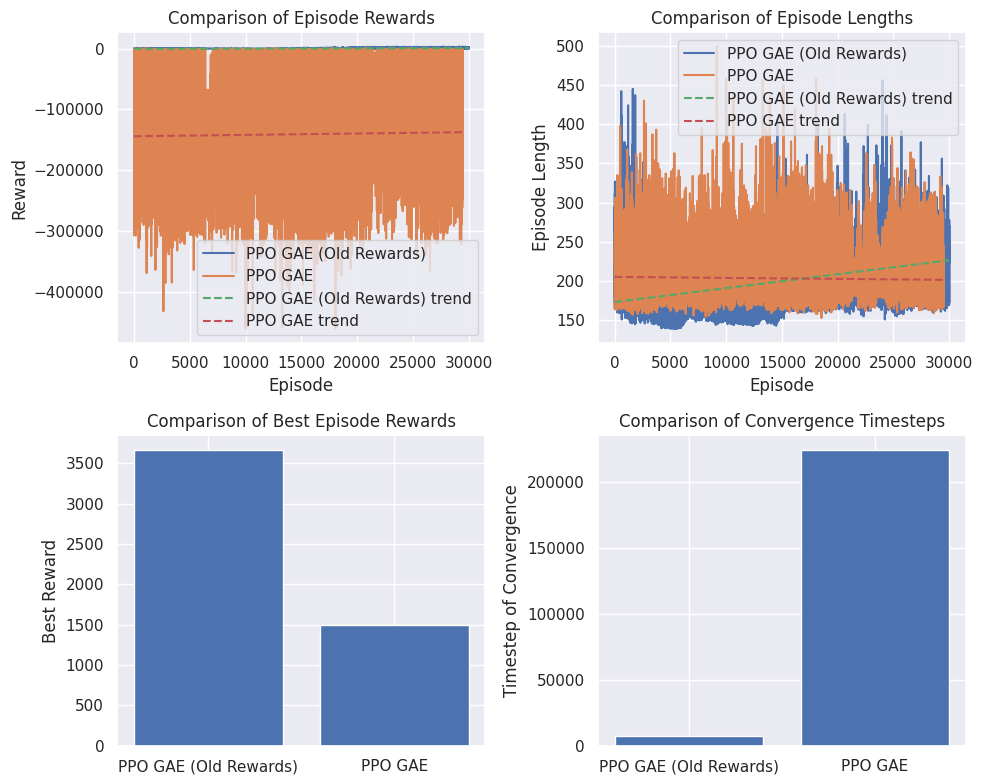

In [11]:
# with open("saved_metrics/metrics_ppo_gae_hyperparam_2.pkl", "rb") as f:
#     loaded_metrics_ppo_gae_hyperparam = pickle.load(f)

with open("saved_metrics/metrics_ppo_gae.pkl", "rb") as f:
    loaded_metrics_ppo_gae = pickle.load(f)
    
metric1 = loaded_metrics_ppo_gae
metric2 = metrics_ppo_gae
label1 = "PPO GAE (Old Rewards)"
label2 = "PPO GAE"

print(len(metric2["episode_rewards"]))
plot_list = [
    lambda ax: compare_episode_rewards(
        ax,
        metric1["episode_rewards"],
        metric2["episode_rewards"],
        label1,
        label2,
    ),
    lambda ax: compare_episode_lengths(
        ax,
        metric1["episode_lengths"],
        metric2["episode_lengths"],
        label1,
        label2,
    ),
    lambda ax: compare_best_rewards(
        ax,
        metric1["best_reward"],
        metric2["best_reward"],
        label1,
        label2,
    ),
    lambda ax: compare_convergence_timestep(
        ax,
        metric1["convergence_timestep"],
        metric2["convergence_timestep"],
        label1,
        label2,
    ),
]
fig = aggregate_plots(plot_list, max_cols=2)
plt.show()

#### Hyperparam tuning

In [7]:
import optuna

state_dim = env.state_dims
action_dim = env.action_dims
has_continuous_action_space = False  # adjust as needed


def objective(trial):
    """
    Objective function for hyperparameter tuning.
    It creates a new PPO agent with suggested hyperparameters,
    trains it using the train() function, and returns the best episode reward.
    """
    # Suggest hyperparameters
    gamma = trial.suggest_float("gamma", 0.90, 0.999, step=0.01)
    eps_clip = trial.suggest_float("eps_clip", 0.1, 0.3, step=0.05)
    K_epochs = trial.suggest_int("K_epochs", 10, 80, step=10)
    # mini_batch_size = trial.suggest_int("mini_batch_size", 32, 256, step=32)
    lr_actor = trial.suggest_float("lr_actor", 1e-4, 1e-3, log=True)
    lr_critic = trial.suggest_float("lr_critic", 1e-4, 1e-3, log=True)
    lam = trial.suggest_float("lam", 0.90, 0.99, step=0.01)

    # Create a new agent using the suggested hyperparameters
    agent = PPO_GAE(
        state_dim=state_dim,
        action_dim=action_dim,
        lr_actor=lr_actor,
        lr_critic=lr_critic,
        gamma=gamma,
        K_epochs=K_epochs,
        eps_clip=eps_clip,
        has_continuous_action_space=has_continuous_action_space,
        lam=lam,
    )

    metrics = train(
        agent,
        env,
        env_name="RocketLanding",
        task="landing",
        max_training_timesteps=1e6,
        convergence_threshold=200,
    )

    # We use the best episode reward as our objective to maximize.
    # You could also return the final average reward or any other metric.
    moving_avg_rewards = metrics["moving_average_reward"]
    final_moving_avg = moving_avg_rewards[-1] if moving_avg_rewards else -1e6

    print(f"Trial completed with final_moving_avg: {final_moving_avg}")
    return final_moving_avg


if __name__ == "__main__":
    # Create an Optuna study to maximize the best reward
    study = optuna.create_study(direction="maximize")

    # Run the optimization (number of trials can be increased for a more thorough search)
    study.optimize(objective, n_trials=20)

    # Print the best trial
    best_trial = study.best_trial
    print("Best trial:")
    print("  Best Reward: ", best_trial.value)
    print("  Hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

[I 2025-03-29 10:49:46,829] A new study created in memory with name: no-name-d361f345-b4bc-4f88-ada2-094dfb45a282


PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_196.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_196.pth
Started training at (GMT) :  2025-03-29 10:49:46


/home/codevardhan/.venv/lib/python3.11/site-packages/optuna/distributions.py:684: UserWarning: The distribution is specified by [0.9, 0.999] and step=0.01, but the range is not divisible by `step`. It will be replaced by [0.9, 0.99].
  warnings.warn(


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 48 		Timestep : 10000 		Average Reward : -126798.76
Episode : 98 		Timestep : 20000 		Average Reward : -119782.76
Episode : 147 		Timestep : 30000 		Average Reward : -121768.15
Episode : 196 		Timestep : 40000 		Average Reward : -106675.88
Episode : 244 		Timestep : 50000 		Average Reward : -106804.71
Episode : 291 		Timestep : 60000 		Average Reward : -90695.2
Episode : 340 		Timestep : 70000 		Average Reward : -116988.84
Episode : 390 		Timestep : 80000 		Average Reward : -148530.29
Episode : 439 		Timestep : 90000 		Average Reward : -158963.01
Episode : 490 		Timestep : 100000 		Average Reward : -143069.15
Model saved at timestep: 100000
Episode : 539 		Timestep : 110000 		Average Reward : -145507.04
Episode : 589 		Timestep : 120000 		Average Reward : -141721.13
Episode : 638 		Timestep : 130000 		Average Reward : -133868.24
Episode : 687 		Timestep : 140000 		Average Reward : -138553.7
Episode : 735 		Timestep : 150000 		Average Reward : -152062.01
Episode : 784 		Timest

[I 2025-03-29 11:06:22,425] Trial 0 finished with value: -152434.70269775926 and parameters: {'gamma': 0.97, 'eps_clip': 0.2, 'K_epochs': 80, 'lr_actor': 0.00012577393682271899, 'lr_critic': 0.00018788119941681838, 'lam': 0.98}. Best is trial 0 with value: -152434.70269775926.


Episode : 4929 		Timestep : 1000000 		Average Reward : -154612.47
Model saved at timestep: 1000000
Finished training at :  2025-03-29 11:06:22
Total training time  :  0:16:36
Trial completed with final_moving_avg: -152434.70269775926
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_197.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_197.pth
Started training at (GMT) :  2025-03-29 11:06:22


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 48 		Timestep : 10000 		Average Reward : -132947.92
Episode : 96 		Timestep : 20000 		Average Reward : -123080.35
Episode : 145 		Timestep : 30000 		Average Reward : -135546.31
Episode : 191 		Timestep : 40000 		Average Reward : -133843.71
Episode : 238 		Timestep : 50000 		Average Reward : -129655.34
Episode : 286 		Timestep : 60000 		Average Reward : -154470.1
Episode : 335 		Timestep : 70000 		Average Reward : -151364.42
Episode : 382 		Timestep : 80000 		Average Reward : -162376.89
Episode : 431 		Timestep : 90000 		Average Reward : -164112.73
Episode : 480 		Timestep : 100000 		Average Reward : -162311.39
Model saved at timestep: 100000
Episode : 528 		Timestep : 110000 		Average Reward : -169152.71
Episode : 575 		Timestep : 120000 		Average Reward : -164291.79
Episode : 623 		Timestep : 130000 		Average Reward : -166099.62
Episode : 672 		Timestep : 140000 		Average Reward : -162593.32
Episode : 722 		Timestep : 150000 		Average Reward : -164191.86
Episode : 773 		Time

[I 2025-03-29 11:21:42,554] Trial 1 finished with value: -175199.81548077322 and parameters: {'gamma': 0.97, 'eps_clip': 0.2, 'K_epochs': 70, 'lr_actor': 0.000136668309354415, 'lr_critic': 0.00016947933493279503, 'lam': 0.91}. Best is trial 0 with value: -152434.70269775926.


Episode : 4914 		Timestep : 1000000 		Average Reward : -157676.82
Model saved at timestep: 1000000
Finished training at :  2025-03-29 11:21:42
Total training time  :  0:15:20
Trial completed with final_moving_avg: -175199.81548077322
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_198.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_198.pth
Started training at (GMT) :  2025-03-29 11:21:42


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 43 		Timestep : 10000 		Average Reward : -128581.5
Episode : 90 		Timestep : 20000 		Average Reward : -132020.54
Episode : 138 		Timestep : 30000 		Average Reward : -145980.15
Episode : 186 		Timestep : 40000 		Average Reward : -122056.54
Episode : 233 		Timestep : 50000 		Average Reward : -145137.29
Episode : 282 		Timestep : 60000 		Average Reward : -139353.6
Episode : 329 		Timestep : 70000 		Average Reward : -150799.5
Episode : 378 		Timestep : 80000 		Average Reward : -143705.6
Episode : 427 		Timestep : 90000 		Average Reward : -156175.85
Episode : 476 		Timestep : 100000 		Average Reward : -160592.58
Model saved at timestep: 100000
Episode : 525 		Timestep : 110000 		Average Reward : -150486.24
Episode : 575 		Timestep : 120000 		Average Reward : -149087.15
Episode : 625 		Timestep : 130000 		Average Reward : -145056.96
Episode : 673 		Timestep : 140000 		Average Reward : -157203.62
Episode : 722 		Timestep : 150000 		Average Reward : -158039.97
Episode : 772 		Timeste

[I 2025-03-29 11:36:32,160] Trial 2 finished with value: -118074.91484904313 and parameters: {'gamma': 0.99, 'eps_clip': 0.1, 'K_epochs': 20, 'lr_actor': 0.00011071644497027509, 'lr_critic': 0.0003460162257487642, 'lam': 0.92}. Best is trial 2 with value: -118074.91484904313.


Episode : 4890 		Timestep : 1000000 		Average Reward : -110534.38
Model saved at timestep: 1000000
Finished training at :  2025-03-29 11:36:32
Total training time  :  0:14:50
Trial completed with final_moving_avg: -118074.91484904313
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_199.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_199.pth
Started training at (GMT) :  2025-03-29 11:36:32


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 48 		Timestep : 10000 		Average Reward : -86095.36
Episode : 95 		Timestep : 20000 		Average Reward : -122443.03
Episode : 144 		Timestep : 30000 		Average Reward : -128690.17
Episode : 190 		Timestep : 40000 		Average Reward : -127456.13
Episode : 238 		Timestep : 50000 		Average Reward : -116209.02
Episode : 285 		Timestep : 60000 		Average Reward : -128760.81
Episode : 334 		Timestep : 70000 		Average Reward : -130058.03
Episode : 381 		Timestep : 80000 		Average Reward : -115223.9
Episode : 429 		Timestep : 90000 		Average Reward : -142350.76
Episode : 478 		Timestep : 100000 		Average Reward : -142703.8
Model saved at timestep: 100000
Episode : 528 		Timestep : 110000 		Average Reward : -126440.79
Episode : 576 		Timestep : 120000 		Average Reward : -100424.1
Episode : 623 		Timestep : 130000 		Average Reward : -77490.38
Episode : 673 		Timestep : 140000 		Average Reward : -141749.94
Episode : 722 		Timestep : 150000 		Average Reward : -151675.42
Episode : 771 		Timestep

[I 2025-03-29 11:51:40,184] Trial 3 finished with value: -158259.80361314956 and parameters: {'gamma': 0.99, 'eps_clip': 0.25, 'K_epochs': 50, 'lr_actor': 0.00027804806387048017, 'lr_critic': 0.00013058807898225577, 'lam': 0.97}. Best is trial 2 with value: -118074.91484904313.


Episode : 4911 		Timestep : 1000000 		Average Reward : -156066.57
Model saved at timestep: 1000000
Finished training at :  2025-03-29 11:51:40
Total training time  :  0:15:08
Trial completed with final_moving_avg: -158259.80361314956
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_200.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_200.pth
Started training at (GMT) :  2025-03-29 11:51:40


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 48 		Timestep : 10000 		Average Reward : -126951.63
Episode : 94 		Timestep : 20000 		Average Reward : -129006.91
Episode : 142 		Timestep : 30000 		Average Reward : -107439.04
Episode : 190 		Timestep : 40000 		Average Reward : -108715.94
Episode : 236 		Timestep : 50000 		Average Reward : -112605.63
Episode : 287 		Timestep : 60000 		Average Reward : -120435.67
Episode : 335 		Timestep : 70000 		Average Reward : -129276.87
Episode : 384 		Timestep : 80000 		Average Reward : -89334.58
Episode : 432 		Timestep : 90000 		Average Reward : -139605.75
Episode : 482 		Timestep : 100000 		Average Reward : -112303.71
Model saved at timestep: 100000
Episode : 530 		Timestep : 110000 		Average Reward : -127934.59
Episode : 578 		Timestep : 120000 		Average Reward : -155014.1
Episode : 629 		Timestep : 130000 		Average Reward : -130751.66
Episode : 677 		Timestep : 140000 		Average Reward : -130061.0
Episode : 726 		Timestep : 150000 		Average Reward : -134225.4
Episode : 771 		Timeste

[I 2025-03-29 12:06:42,544] Trial 4 finished with value: -159373.74518394444 and parameters: {'gamma': 0.92, 'eps_clip': 0.15000000000000002, 'K_epochs': 50, 'lr_actor': 0.0007750017140260727, 'lr_critic': 0.00047471728521312237, 'lam': 0.96}. Best is trial 2 with value: -118074.91484904313.


Episode : 4867 		Timestep : 1000000 		Average Reward : -159808.53
Model saved at timestep: 1000000
Finished training at :  2025-03-29 12:06:42
Total training time  :  0:15:02
Trial completed with final_moving_avg: -159373.74518394444
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_201.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_201.pth
Started training at (GMT) :  2025-03-29 12:06:42


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 48 		Timestep : 10000 		Average Reward : -120356.47
Episode : 97 		Timestep : 20000 		Average Reward : -140080.44
Episode : 147 		Timestep : 30000 		Average Reward : -139429.82
Episode : 198 		Timestep : 40000 		Average Reward : -151452.19
Episode : 247 		Timestep : 50000 		Average Reward : -158537.02
Episode : 297 		Timestep : 60000 		Average Reward : -153791.63
Episode : 348 		Timestep : 70000 		Average Reward : -131735.38
Episode : 397 		Timestep : 80000 		Average Reward : -159254.33
Episode : 445 		Timestep : 90000 		Average Reward : -170342.91
Episode : 495 		Timestep : 100000 		Average Reward : -153563.78
Model saved at timestep: 100000
Episode : 544 		Timestep : 110000 		Average Reward : -164171.41
Episode : 593 		Timestep : 120000 		Average Reward : -165139.46
Episode : 643 		Timestep : 130000 		Average Reward : -156274.23
Episode : 693 		Timestep : 140000 		Average Reward : -159934.79
Episode : 744 		Timestep : 150000 		Average Reward : -156266.59
Episode : 793 		Tim

[I 2025-03-29 12:21:41,560] Trial 5 finished with value: -165640.48578588077 and parameters: {'gamma': 0.99, 'eps_clip': 0.2, 'K_epochs': 40, 'lr_actor': 0.00016505946819564662, 'lr_critic': 0.0001170653075207823, 'lam': 0.99}. Best is trial 2 with value: -118074.91484904313.


Episode : 4945 		Timestep : 1000000 		Average Reward : -155248.96
Model saved at timestep: 1000000
Finished training at :  2025-03-29 12:21:41
Total training time  :  0:14:59
Trial completed with final_moving_avg: -165640.48578588077
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_202.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_202.pth
Started training at (GMT) :  2025-03-29 12:21:41


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 45 		Timestep : 10000 		Average Reward : -120888.08
Episode : 93 		Timestep : 20000 		Average Reward : -109415.61
Episode : 140 		Timestep : 30000 		Average Reward : -121116.3
Episode : 189 		Timestep : 40000 		Average Reward : -91144.27
Episode : 236 		Timestep : 50000 		Average Reward : -114208.0
Episode : 284 		Timestep : 60000 		Average Reward : -109671.53
Episode : 332 		Timestep : 70000 		Average Reward : -121486.17
Episode : 380 		Timestep : 80000 		Average Reward : -92666.58
Episode : 427 		Timestep : 90000 		Average Reward : -95343.24
Episode : 475 		Timestep : 100000 		Average Reward : -120043.94
Model saved at timestep: 100000
Episode : 522 		Timestep : 110000 		Average Reward : -120852.61
Episode : 571 		Timestep : 120000 		Average Reward : -114063.82
Episode : 621 		Timestep : 130000 		Average Reward : -100783.53
Episode : 668 		Timestep : 140000 		Average Reward : -111458.94
Episode : 718 		Timestep : 150000 		Average Reward : -108279.1
Episode : 767 		Timestep 

[I 2025-03-29 12:36:29,272] Trial 6 finished with value: -166333.77539371414 and parameters: {'gamma': 0.91, 'eps_clip': 0.1, 'K_epochs': 20, 'lr_actor': 0.0001006240922123592, 'lr_critic': 0.00012407553045715525, 'lam': 0.9400000000000001}. Best is trial 2 with value: -118074.91484904313.


Episode : 4873 		Timestep : 1000000 		Average Reward : -155390.98
Model saved at timestep: 1000000
Finished training at :  2025-03-29 12:36:29
Total training time  :  0:14:48
Trial completed with final_moving_avg: -166333.77539371414
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_203.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_203.pth
Started training at (GMT) :  2025-03-29 12:36:29


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 49 		Timestep : 10000 		Average Reward : -117223.84
Episode : 98 		Timestep : 20000 		Average Reward : -153008.75
Episode : 148 		Timestep : 30000 		Average Reward : -155488.5
Episode : 197 		Timestep : 40000 		Average Reward : -158572.01
Episode : 247 		Timestep : 50000 		Average Reward : -151577.41
Episode : 297 		Timestep : 60000 		Average Reward : -150845.98
Episode : 346 		Timestep : 70000 		Average Reward : -148855.46
Episode : 397 		Timestep : 80000 		Average Reward : -150870.97
Episode : 446 		Timestep : 90000 		Average Reward : -153513.68
Episode : 495 		Timestep : 100000 		Average Reward : -149659.92
Model saved at timestep: 100000
Episode : 544 		Timestep : 110000 		Average Reward : -145047.35
Episode : 593 		Timestep : 120000 		Average Reward : -150450.53
Episode : 643 		Timestep : 130000 		Average Reward : -148828.29
Episode : 692 		Timestep : 140000 		Average Reward : -153812.89
Episode : 743 		Timestep : 150000 		Average Reward : -144191.54
Episode : 792 		Time

[I 2025-03-29 12:51:12,872] Trial 7 finished with value: -170244.04941083273 and parameters: {'gamma': 0.98, 'eps_clip': 0.3, 'K_epochs': 10, 'lr_actor': 0.0004945787386294268, 'lr_critic': 0.0007827343725425518, 'lam': 0.9500000000000001}. Best is trial 2 with value: -118074.91484904313.


Episode : 4898 		Timestep : 1000000 		Average Reward : -140768.21
Model saved at timestep: 1000000
Finished training at :  2025-03-29 12:51:12
Total training time  :  0:14:43
Trial completed with final_moving_avg: -170244.04941083273
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_204.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_204.pth
Started training at (GMT) :  2025-03-29 12:51:12


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 47 		Timestep : 10000 		Average Reward : -140738.7
Episode : 94 		Timestep : 20000 		Average Reward : -106395.38
Episode : 144 		Timestep : 30000 		Average Reward : -109167.53
Episode : 191 		Timestep : 40000 		Average Reward : -122435.52
Episode : 237 		Timestep : 50000 		Average Reward : -134250.89
Episode : 286 		Timestep : 60000 		Average Reward : -142627.96
Episode : 335 		Timestep : 70000 		Average Reward : -116892.39
Episode : 385 		Timestep : 80000 		Average Reward : -143561.34
Episode : 435 		Timestep : 90000 		Average Reward : -145917.14
Episode : 483 		Timestep : 100000 		Average Reward : -159392.8
Model saved at timestep: 100000
Episode : 532 		Timestep : 110000 		Average Reward : -158399.87
Episode : 582 		Timestep : 120000 		Average Reward : -156232.42
Episode : 633 		Timestep : 130000 		Average Reward : -139020.36
Episode : 682 		Timestep : 140000 		Average Reward : -151756.99
Episode : 731 		Timestep : 150000 		Average Reward : -155464.64
Episode : 780 		Times

[I 2025-03-29 13:06:01,831] Trial 8 finished with value: -133320.55021363567 and parameters: {'gamma': 0.93, 'eps_clip': 0.1, 'K_epochs': 30, 'lr_actor': 0.00019290722787609072, 'lr_critic': 0.0002763056535906761, 'lam': 0.9}. Best is trial 2 with value: -118074.91484904313.


Episode : 4936 		Timestep : 1000000 		Average Reward : -132259.44
Model saved at timestep: 1000000
Finished training at :  2025-03-29 13:06:01
Total training time  :  0:14:49
Trial completed with final_moving_avg: -133320.55021363567
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_205.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_205.pth
Started training at (GMT) :  2025-03-29 13:06:01


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 46 		Timestep : 10000 		Average Reward : -136611.81
Episode : 94 		Timestep : 20000 		Average Reward : -127899.29
Episode : 144 		Timestep : 30000 		Average Reward : -110938.57
Episode : 192 		Timestep : 40000 		Average Reward : -142775.98
Episode : 242 		Timestep : 50000 		Average Reward : -128925.89
Episode : 289 		Timestep : 60000 		Average Reward : -136312.2
Episode : 339 		Timestep : 70000 		Average Reward : -137780.2
Episode : 388 		Timestep : 80000 		Average Reward : -129455.64
Episode : 437 		Timestep : 90000 		Average Reward : -140978.0
Episode : 486 		Timestep : 100000 		Average Reward : -144945.61
Model saved at timestep: 100000
Episode : 535 		Timestep : 110000 		Average Reward : -138245.47
Episode : 584 		Timestep : 120000 		Average Reward : -140484.34
Episode : 631 		Timestep : 130000 		Average Reward : -158705.24
Episode : 680 		Timestep : 140000 		Average Reward : -158232.58
Episode : 729 		Timestep : 150000 		Average Reward : -157113.79
Episode : 777 		Timest

[I 2025-03-29 13:20:42,710] Trial 9 finished with value: -166875.59938366295 and parameters: {'gamma': 0.96, 'eps_clip': 0.15000000000000002, 'K_epochs': 10, 'lr_actor': 0.00015974850947862525, 'lr_critic': 0.0006584099790069822, 'lam': 0.92}. Best is trial 2 with value: -118074.91484904313.


Episode : 4889 		Timestep : 1000000 		Average Reward : -152510.44
Model saved at timestep: 1000000
Finished training at :  2025-03-29 13:20:42
Total training time  :  0:14:41
Trial completed with final_moving_avg: -166875.59938366295
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_206.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_206.pth
Started training at (GMT) :  2025-03-29 13:20:42


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 49 		Timestep : 10000 		Average Reward : -113791.84
Episode : 99 		Timestep : 20000 		Average Reward : -96541.31
Episode : 146 		Timestep : 30000 		Average Reward : -117565.04
Episode : 195 		Timestep : 40000 		Average Reward : -96594.34
Episode : 243 		Timestep : 50000 		Average Reward : -79013.84
Episode : 290 		Timestep : 60000 		Average Reward : -108827.8
Episode : 337 		Timestep : 70000 		Average Reward : -93079.02
Episode : 385 		Timestep : 80000 		Average Reward : -122621.27
Episode : 434 		Timestep : 90000 		Average Reward : -137314.89
Episode : 483 		Timestep : 100000 		Average Reward : -145651.08
Model saved at timestep: 100000
Episode : 531 		Timestep : 110000 		Average Reward : -149475.29
Episode : 582 		Timestep : 120000 		Average Reward : -140856.98
Episode : 632 		Timestep : 130000 		Average Reward : -150895.85
Episode : 682 		Timestep : 140000 		Average Reward : -152809.52
Episode : 732 		Timestep : 150000 		Average Reward : -148872.32
Episode : 779 		Timestep

[I 2025-03-29 13:35:25,263] Trial 10 finished with value: -78978.34511576961 and parameters: {'gamma': 0.9500000000000001, 'eps_clip': 0.1, 'K_epochs': 30, 'lr_actor': 0.0003195796305627065, 'lr_critic': 0.00038952491402210034, 'lam': 0.93}. Best is trial 10 with value: -78978.34511576961.


Episode : 4816 		Timestep : 1000000 		Average Reward : -95897.39
Model saved at timestep: 1000000
Finished training at :  2025-03-29 13:35:25
Total training time  :  0:14:43
Trial completed with final_moving_avg: -78978.34511576961
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_207.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_207.pth
Started training at (GMT) :  2025-03-29 13:35:25


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 47 		Timestep : 10000 		Average Reward : -97523.51
Episode : 95 		Timestep : 20000 		Average Reward : -114420.23
Episode : 144 		Timestep : 30000 		Average Reward : -125344.22
Episode : 194 		Timestep : 40000 		Average Reward : -118937.65
Episode : 245 		Timestep : 50000 		Average Reward : -114576.76
Episode : 291 		Timestep : 60000 		Average Reward : -124285.99
Episode : 338 		Timestep : 70000 		Average Reward : -141515.79
Episode : 388 		Timestep : 80000 		Average Reward : -125500.29
Episode : 435 		Timestep : 90000 		Average Reward : -139616.7
Episode : 484 		Timestep : 100000 		Average Reward : -141974.7
Model saved at timestep: 100000
Episode : 531 		Timestep : 110000 		Average Reward : -143589.39
Episode : 580 		Timestep : 120000 		Average Reward : -132733.34
Episode : 629 		Timestep : 130000 		Average Reward : -128787.28
Episode : 678 		Timestep : 140000 		Average Reward : -132745.81
Episode : 727 		Timestep : 150000 		Average Reward : -123698.17
Episode : 775 		Timest

[I 2025-03-29 13:50:28,253] Trial 11 finished with value: -141291.7824580259 and parameters: {'gamma': 0.9400000000000001, 'eps_clip': 0.1, 'K_epochs': 30, 'lr_actor': 0.00033794324010372466, 'lr_critic': 0.00037118514937424323, 'lam': 0.93}. Best is trial 10 with value: -78978.34511576961.


Episode : 4922 		Timestep : 1000000 		Average Reward : -149932.91
Model saved at timestep: 1000000
Finished training at :  2025-03-29 13:50:28
Total training time  :  0:15:03
Trial completed with final_moving_avg: -141291.7824580259
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_208.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_208.pth
Started training at (GMT) :  2025-03-29 13:50:28


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 47 		Timestep : 10000 		Average Reward : -111887.51
Episode : 94 		Timestep : 20000 		Average Reward : -124513.21
Episode : 142 		Timestep : 30000 		Average Reward : -127691.48
Episode : 190 		Timestep : 40000 		Average Reward : -133317.04
Episode : 239 		Timestep : 50000 		Average Reward : -139658.62
Episode : 288 		Timestep : 60000 		Average Reward : -137147.71
Episode : 337 		Timestep : 70000 		Average Reward : -121208.92
Episode : 386 		Timestep : 80000 		Average Reward : -120084.85
Episode : 434 		Timestep : 90000 		Average Reward : -146919.08
Episode : 483 		Timestep : 100000 		Average Reward : -138734.16
Model saved at timestep: 100000
Episode : 532 		Timestep : 110000 		Average Reward : -135992.98
Episode : 582 		Timestep : 120000 		Average Reward : -142499.04
Episode : 633 		Timestep : 130000 		Average Reward : -152967.19
Episode : 684 		Timestep : 140000 		Average Reward : -144455.74
Episode : 734 		Timestep : 150000 		Average Reward : -151335.69
Episode : 783 		Tim

[I 2025-03-29 14:05:24,230] Trial 12 finished with value: -150964.7129129835 and parameters: {'gamma': 0.9500000000000001, 'eps_clip': 0.15000000000000002, 'K_epochs': 30, 'lr_actor': 0.00027628361223232874, 'lr_critic': 0.0002799699151191994, 'lam': 0.93}. Best is trial 10 with value: -78978.34511576961.


Episode : 4856 		Timestep : 1000000 		Average Reward : -140984.9
Model saved at timestep: 1000000
Finished training at :  2025-03-29 14:05:24
Total training time  :  0:14:56
Trial completed with final_moving_avg: -150964.7129129835
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_209.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_209.pth
Started training at (GMT) :  2025-03-29 14:05:24


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 47 		Timestep : 10000 		Average Reward : -100011.47
Episode : 96 		Timestep : 20000 		Average Reward : -113322.17
Episode : 143 		Timestep : 30000 		Average Reward : -128112.97
Episode : 191 		Timestep : 40000 		Average Reward : -113787.35
Episode : 241 		Timestep : 50000 		Average Reward : -67339.97
Episode : 290 		Timestep : 60000 		Average Reward : -116056.71
Episode : 341 		Timestep : 70000 		Average Reward : -93916.72
Episode : 387 		Timestep : 80000 		Average Reward : -142555.19
Episode : 432 		Timestep : 90000 		Average Reward : -159117.3
Episode : 479 		Timestep : 100000 		Average Reward : -157102.7
Model saved at timestep: 100000
Episode : 525 		Timestep : 110000 		Average Reward : -132493.4
Episode : 574 		Timestep : 120000 		Average Reward : -144787.39
Episode : 622 		Timestep : 130000 		Average Reward : -150058.06
Episode : 668 		Timestep : 140000 		Average Reward : -149815.41
Episode : 717 		Timestep : 150000 		Average Reward : -142225.51
Episode : 767 		Timestep

[I 2025-03-29 14:20:10,866] Trial 13 finished with value: -89731.50565253317 and parameters: {'gamma': 0.9, 'eps_clip': 0.1, 'K_epochs': 20, 'lr_actor': 0.00034598024062945003, 'lr_critic': 0.0005015977332677494, 'lam': 0.92}. Best is trial 10 with value: -78978.34511576961.


Episode : 4869 		Timestep : 1000000 		Average Reward : -108560.44
Model saved at timestep: 1000000
Finished training at :  2025-03-29 14:20:10
Total training time  :  0:14:46
Trial completed with final_moving_avg: -89731.50565253317
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_210.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_210.pth
Started training at (GMT) :  2025-03-29 14:20:10


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 48 		Timestep : 10000 		Average Reward : -122947.58
Episode : 96 		Timestep : 20000 		Average Reward : -136507.53
Episode : 143 		Timestep : 30000 		Average Reward : -129216.67
Episode : 191 		Timestep : 40000 		Average Reward : -150705.97
Episode : 239 		Timestep : 50000 		Average Reward : -120086.38
Episode : 287 		Timestep : 60000 		Average Reward : -130904.28
Episode : 333 		Timestep : 70000 		Average Reward : -136932.8
Episode : 380 		Timestep : 80000 		Average Reward : -157121.83
Episode : 428 		Timestep : 90000 		Average Reward : -116959.28
Episode : 474 		Timestep : 100000 		Average Reward : -122704.09
Model saved at timestep: 100000
Episode : 524 		Timestep : 110000 		Average Reward : -136521.18
Episode : 572 		Timestep : 120000 		Average Reward : -148174.82
Episode : 619 		Timestep : 130000 		Average Reward : -154927.95
Episode : 669 		Timestep : 140000 		Average Reward : -137966.96
Episode : 718 		Timestep : 150000 		Average Reward : -145306.32
Episode : 767 		Time

[I 2025-03-29 14:35:22,393] Trial 14 finished with value: -160692.17807247053 and parameters: {'gamma': 0.91, 'eps_clip': 0.15000000000000002, 'K_epochs': 40, 'lr_actor': 0.00046339337490363547, 'lr_critic': 0.0005298310138165817, 'lam': 0.9}. Best is trial 10 with value: -78978.34511576961.


Episode : 4794 		Timestep : 1000000 		Average Reward : -162752.06
Model saved at timestep: 1000000
Finished training at :  2025-03-29 14:35:22
Total training time  :  0:15:12
Trial completed with final_moving_avg: -160692.17807247053
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_211.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_211.pth
Started training at (GMT) :  2025-03-29 14:35:22


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 47 		Timestep : 10000 		Average Reward : -110125.66
Episode : 94 		Timestep : 20000 		Average Reward : -129531.43
Episode : 142 		Timestep : 30000 		Average Reward : -128978.59
Episode : 189 		Timestep : 40000 		Average Reward : -107722.43
Episode : 236 		Timestep : 50000 		Average Reward : -140569.94
Episode : 284 		Timestep : 60000 		Average Reward : -139856.39
Episode : 333 		Timestep : 70000 		Average Reward : -130746.68
Episode : 380 		Timestep : 80000 		Average Reward : -136749.65
Episode : 427 		Timestep : 90000 		Average Reward : -141070.76
Episode : 475 		Timestep : 100000 		Average Reward : -128316.28
Model saved at timestep: 100000
Episode : 521 		Timestep : 110000 		Average Reward : -150288.54
Episode : 566 		Timestep : 120000 		Average Reward : -159242.25
Episode : 613 		Timestep : 130000 		Average Reward : -133734.49
Episode : 658 		Timestep : 140000 		Average Reward : -156182.06
Episode : 704 		Timestep : 150000 		Average Reward : -135001.31
Episode : 751 		Tim

[I 2025-03-29 14:50:46,795] Trial 15 finished with value: -158243.60163275205 and parameters: {'gamma': 0.9, 'eps_clip': 0.1, 'K_epochs': 60, 'lr_actor': 0.0005071524342761899, 'lr_critic': 0.0008851084557692341, 'lam': 0.9400000000000001}. Best is trial 10 with value: -78978.34511576961.


Episode : 4761 		Timestep : 1000000 		Average Reward : -136130.97
Model saved at timestep: 1000000
Finished training at :  2025-03-29 14:50:46
Total training time  :  0:15:24
Trial completed with final_moving_avg: -158243.60163275205
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_212.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_212.pth
Started training at (GMT) :  2025-03-29 14:50:46


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 46 		Timestep : 10000 		Average Reward : -100890.62
Episode : 95 		Timestep : 20000 		Average Reward : -81392.1
Episode : 143 		Timestep : 30000 		Average Reward : -56409.86
Episode : 191 		Timestep : 40000 		Average Reward : -100278.55
Episode : 241 		Timestep : 50000 		Average Reward : -114223.62
Episode : 290 		Timestep : 60000 		Average Reward : -147010.21
Episode : 339 		Timestep : 70000 		Average Reward : -162698.35
Episode : 388 		Timestep : 80000 		Average Reward : -159391.45
Episode : 435 		Timestep : 90000 		Average Reward : -144588.1
Episode : 483 		Timestep : 100000 		Average Reward : -152783.62
Model saved at timestep: 100000
Episode : 532 		Timestep : 110000 		Average Reward : -125515.97
Episode : 580 		Timestep : 120000 		Average Reward : -166231.22
Episode : 630 		Timestep : 130000 		Average Reward : -147876.47
Episode : 679 		Timestep : 140000 		Average Reward : -147240.8
Episode : 729 		Timestep : 150000 		Average Reward : -148356.45
Episode : 777 		Timestep

[I 2025-03-29 15:05:33,255] Trial 16 finished with value: -162973.80185440462 and parameters: {'gamma': 0.9400000000000001, 'eps_clip': 0.25, 'K_epochs': 20, 'lr_actor': 0.0003662805666105126, 'lr_critic': 0.00047243562378525874, 'lam': 0.92}. Best is trial 10 with value: -78978.34511576961.


Episode : 4864 		Timestep : 1000000 		Average Reward : -145380.89
Model saved at timestep: 1000000
Finished training at :  2025-03-29 15:05:33
Total training time  :  0:14:47
Trial completed with final_moving_avg: -162973.80185440462
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_213.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_213.pth
Started training at (GMT) :  2025-03-29 15:05:33


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 47 		Timestep : 10000 		Average Reward : -106029.15
Episode : 91 		Timestep : 20000 		Average Reward : -120145.11
Episode : 137 		Timestep : 30000 		Average Reward : -154237.38
Episode : 184 		Timestep : 40000 		Average Reward : -155473.77
Episode : 233 		Timestep : 50000 		Average Reward : -150651.08
Episode : 282 		Timestep : 60000 		Average Reward : -165982.02
Episode : 330 		Timestep : 70000 		Average Reward : -174095.64
Episode : 380 		Timestep : 80000 		Average Reward : -160156.22
Episode : 428 		Timestep : 90000 		Average Reward : -172384.04
Episode : 479 		Timestep : 100000 		Average Reward : -163279.41
Model saved at timestep: 100000
Episode : 528 		Timestep : 110000 		Average Reward : -166509.71
Episode : 578 		Timestep : 120000 		Average Reward : -163844.27
Episode : 628 		Timestep : 130000 		Average Reward : -161419.78
Episode : 677 		Timestep : 140000 		Average Reward : -162489.18
Episode : 728 		Timestep : 150000 		Average Reward : -156088.84
Episode : 778 		Tim

[I 2025-03-29 15:20:11,999] Trial 17 finished with value: -130605.11240044508 and parameters: {'gamma': 0.9500000000000001, 'eps_clip': 0.15000000000000002, 'K_epochs': 10, 'lr_actor': 0.0009564019781709101, 'lr_critic': 0.00022094812013786653, 'lam': 0.9500000000000001}. Best is trial 10 with value: -78978.34511576961.


Episode : 4874 		Timestep : 1000000 		Average Reward : -146033.43
Model saved at timestep: 1000000
Finished training at :  2025-03-29 15:20:11
Total training time  :  0:14:38
Trial completed with final_moving_avg: -130605.11240044508
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_214.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_214.pth
Started training at (GMT) :  2025-03-29 15:20:12


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 47 		Timestep : 10000 		Average Reward : -116266.9
Episode : 93 		Timestep : 20000 		Average Reward : -133768.31
Episode : 141 		Timestep : 30000 		Average Reward : -112541.5
Episode : 191 		Timestep : 40000 		Average Reward : -99737.82
Episode : 239 		Timestep : 50000 		Average Reward : -126898.59
Episode : 287 		Timestep : 60000 		Average Reward : -119824.03
Episode : 336 		Timestep : 70000 		Average Reward : -137367.13
Episode : 384 		Timestep : 80000 		Average Reward : -153874.12
Episode : 433 		Timestep : 90000 		Average Reward : -159696.24
Episode : 482 		Timestep : 100000 		Average Reward : -130195.93
Model saved at timestep: 100000
Episode : 531 		Timestep : 110000 		Average Reward : -128892.44
Episode : 576 		Timestep : 120000 		Average Reward : -115925.18
Episode : 624 		Timestep : 130000 		Average Reward : -135934.53
Episode : 670 		Timestep : 140000 		Average Reward : -165765.81
Episode : 718 		Timestep : 150000 		Average Reward : -117849.0
Episode : 768 		Timeste

[I 2025-03-29 15:35:11,009] Trial 18 finished with value: -164433.27217750385 and parameters: {'gamma': 0.92, 'eps_clip': 0.25, 'K_epochs': 30, 'lr_actor': 0.00020630968547788786, 'lr_critic': 0.0006719744241519808, 'lam': 0.93}. Best is trial 10 with value: -78978.34511576961.


Episode : 4868 		Timestep : 1000000 		Average Reward : -135234.83
Model saved at timestep: 1000000
Finished training at :  2025-03-29 15:35:11
Total training time  :  0:14:59
Trial completed with final_moving_avg: -164433.27217750385
PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_215.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_215.pth
Started training at (GMT) :  2025-03-29 15:35:11


Training Timesteps:   0%|          | 0/1000000.0 [00:00<?, ?it/s]

Episode : 47 		Timestep : 10000 		Average Reward : -110177.99
Episode : 96 		Timestep : 20000 		Average Reward : -106950.85
Episode : 145 		Timestep : 30000 		Average Reward : -111479.41
Episode : 194 		Timestep : 40000 		Average Reward : -121378.14
Episode : 244 		Timestep : 50000 		Average Reward : -110804.26
Episode : 292 		Timestep : 60000 		Average Reward : -128067.13
Episode : 341 		Timestep : 70000 		Average Reward : -123800.54
Episode : 389 		Timestep : 80000 		Average Reward : -155847.39
Episode : 438 		Timestep : 90000 		Average Reward : -149454.96
Episode : 488 		Timestep : 100000 		Average Reward : -154208.54
Model saved at timestep: 100000
Episode : 537 		Timestep : 110000 		Average Reward : -134761.9
Episode : 585 		Timestep : 120000 		Average Reward : -155561.32
Episode : 633 		Timestep : 130000 		Average Reward : -150434.3
Episode : 681 		Timestep : 140000 		Average Reward : -153347.74
Episode : 732 		Timestep : 150000 		Average Reward : -132305.6
Episode : 782 		Timest

[I 2025-03-29 15:50:22,547] Trial 19 finished with value: -48962.01579492423 and parameters: {'gamma': 0.93, 'eps_clip': 0.1, 'K_epochs': 40, 'lr_actor': 0.0006770820788054971, 'lr_critic': 0.000414271048694982, 'lam': 0.91}. Best is trial 19 with value: -48962.01579492423.


Episode : 4872 		Timestep : 1000000 		Average Reward : -90481.63
Model saved at timestep: 1000000
Finished training at :  2025-03-29 15:50:22
Total training time  :  0:15:11
Trial completed with final_moving_avg: -48962.01579492423
Best trial:
  Best Reward:  -48962.01579492423
  Hyperparameters:
    gamma: 0.93
    eps_clip: 0.1
    K_epochs: 40
    lr_actor: 0.0006770820788054971
    lr_critic: 0.000414271048694982
    lam: 0.91


In [8]:
best_trial.params

{'gamma': 0.93,
 'eps_clip': 0.1,
 'K_epochs': 40,
 'lr_actor': 0.0006770820788054971,
 'lr_critic': 0.000414271048694982,
 'lam': 0.91}

In [9]:
# State and action dimensions
state_dim = env.state_dims
action_dim = env.action_dims

# lr_actor = 0.0003
# lr_critic = 0.001
# K_epochs = 80
# eps_clip = 0.2
# gamma = 0.99
has_continuous_action_space = False
# mini_batch_size = 64
# lam = 0.95

# hyperparameter

# gamma = 0.96
# eps_clip = 0.1
# K_epochs = 70
# lr_actor = 0.00010154485581168334
# lr_critic = 0.0006998820449991889
# lam = 0.9

# hyperparameters (trained for longer)
# gamma = trial.suggest_float("gamma", 0.90, 0.999, step=0.01)
# eps_clip = trial.suggest_float("eps_clip", 0.1, 0.3, step=0.05)
# K_epochs = trial.suggest_int("K_epochs", 10, 80, step=10)
# # mini_batch_size = trial.suggest_int("mini_batch_size", 32, 256, step=32)
# lr_actor = trial.suggest_float("lr_actor", 1e-4, 1e-3, log=True)
# lr_critic = trial.suggest_float("lr_critic", 1e-4, 1e-3, log=True)
# lam = trial.suggest_float("lam", 0.90, 0.99, step=0.01)

best_params = best_trial.params
gamma = best_params["gamma"]
eps_clip = best_params["eps_clip"]
K_epochs = best_params["K_epochs"]
lr_actor = best_params["lr_actor"]
lr_critic = best_params["lr_critic"]
lam = best_params["lam"]

ppo_gae_agent = PPO_GAE(
    state_dim,
    action_dim,
    lr_actor,
    lr_critic,
    gamma,
    K_epochs,
    eps_clip,
    has_continuous_action_space,
    lam=lam,
)

In [10]:
metrics_ppo_gae = train(
    ppo_gae_agent,
    env,
    env_name="RocketLanding",
    task="landing",
    max_training_timesteps=6e6,
    convergence_threshold=200,
)

PPO
Logging at : PPO_logs/RocketLanding/PPO_RocketLanding_log_216.csv
Save checkpoint path : PPO_preTrained/RocketLanding/PPO_RocketLanding_0_216.pth
Started training at (GMT) :  2025-03-29 15:50:22


Training Timesteps:   0%|          | 0/6000000.0 [00:00<?, ?it/s]

Episode : 47 		Timestep : 10000 		Average Reward : -119290.94
Episode : 95 		Timestep : 20000 		Average Reward : -102861.19
Episode : 143 		Timestep : 30000 		Average Reward : -130258.62
Episode : 192 		Timestep : 40000 		Average Reward : -128777.83
Episode : 242 		Timestep : 50000 		Average Reward : -102130.58
Episode : 290 		Timestep : 60000 		Average Reward : -118244.83
Episode : 339 		Timestep : 70000 		Average Reward : -134387.15
Episode : 388 		Timestep : 80000 		Average Reward : -116163.42
Episode : 436 		Timestep : 90000 		Average Reward : -110215.75
Episode : 481 		Timestep : 100000 		Average Reward : -145915.67
Model saved at timestep: 100000
Episode : 528 		Timestep : 110000 		Average Reward : -109916.56
Episode : 577 		Timestep : 120000 		Average Reward : -116771.88
Episode : 625 		Timestep : 130000 		Average Reward : -108109.88
Episode : 674 		Timestep : 140000 		Average Reward : -98717.29
Episode : 722 		Timestep : 150000 		Average Reward : -124156.03
Episode : 772 		Time

#### PPO (GAE) vs Safe PPO

In [6]:
# State and action dimensions
state_dim = env.state_dims
action_dim = env.action_dims

# lr_actor = 0.0003
# lr_critic = 0.001
# K_epochs = 80
# eps_clip = 0.2
# gamma = 0.99
has_continuous_action_space = False
# mini_batch_size = 64
# lam = 0.95

# hyperparameter

# gamma = 0.96
# eps_clip = 0.1
# K_epochs = 70
# lr_actor = 0.00010154485581168334
# lr_critic = 0.0006998820449991889
# lam = 0.9

# hyperparameters (trained for longer)

gamma = 0.93
eps_clip = 0.3
K_epochs = 10
lr_actor = 0.0009234592057581404
lr_critic = 0.000379521213081862
lam = 0.93

ppo_gae_agent = PPO_GAE(
    state_dim,
    action_dim,
    lr_actor,
    lr_critic,
    gamma,
    K_epochs,
    eps_clip,
    has_continuous_action_space,
    lam=lam,
)


ppo_safe_agent = PPO_SAFE(
    state_dim=state_dim,
    action_dim=action_dim,
    lr_actor=lr_actor,
    lr_critic=lr_critic,
    gamma=gamma,
    lam=lam,
    eps_clip=eps_clip,
    K_epochs=K_epochs,
)

# def __init__(
#     self,
#     state_dim,
#     action_dim,
#     lr_actor=3e-4,
#     lr_critic=3e-4,
#     gamma=0.99,
#     lam=0.95,
#     eps_clip=0.2,
#     K_epochs=10,
#     cost_limit=0.1,
#     alpha_lr=1e-2,
# ):

In [8]:
# metrics_ppo_gae = train(
#     ppo_safe_agent,
#     env,
#     env_name="RocketLanding",
#     task="landing",
#     max_training_timesteps=6e6,
#     convergence_threshold=200,
# )

4836


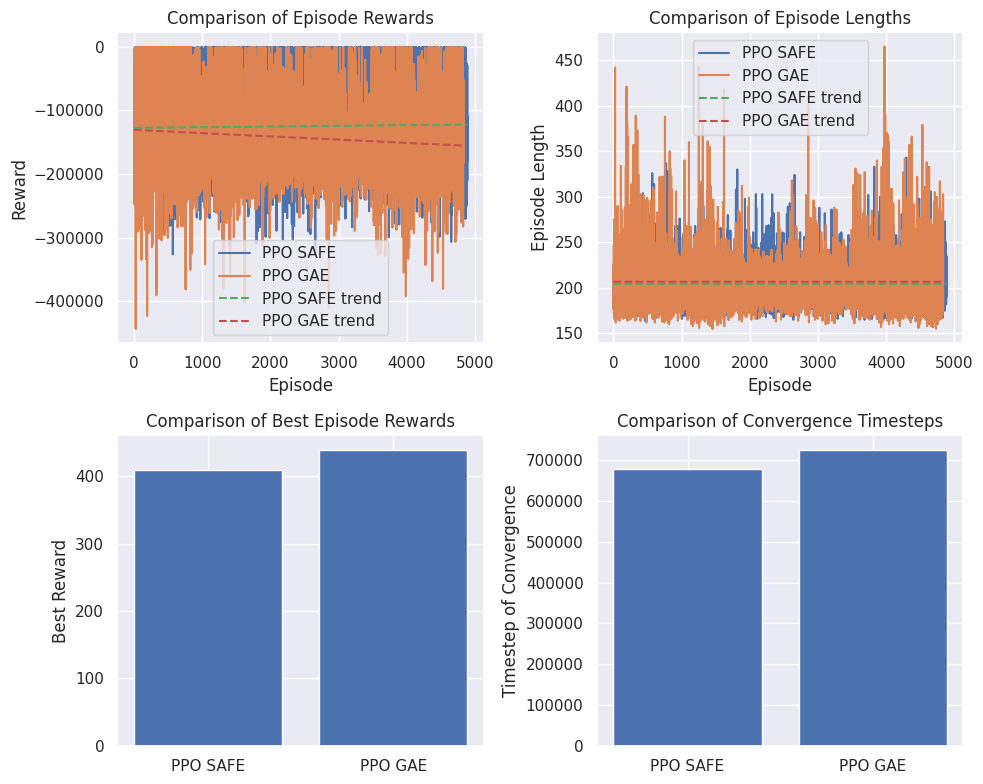

In [13]:
with open("saved_metrics/metrics_ppo_gae.pkl", "rb") as f:
    loaded_metrics_ppo_gae = pickle.load(f)

with open("saved_metrics/metrics_ppo_safe.pkl", "rb") as f:
    loaded_metrics_ppo_safe = pickle.load(f)
    
metric1 = loaded_metrics_ppo_safe
metric2 = loaded_metrics_ppo_gae
label1 = "PPO SAFE"
label2 = "PPO GAE"

print(len(metric2["episode_rewards"]))
plot_list = [
    lambda ax: compare_episode_rewards(
        ax,
        metric1["episode_rewards"],
        metric2["episode_rewards"],
        label1,
        label2,
    ),
    lambda ax: compare_episode_lengths(
        ax,
        metric1["episode_lengths"],
        metric2["episode_lengths"],
        label1,
        label2,
    ),
    lambda ax: compare_best_rewards(
        ax,
        metric1["best_reward"],
        metric2["best_reward"],
        label1,
        label2,
    ),
    lambda ax: compare_convergence_timestep(
        ax,
        metric1["convergence_timestep"],
        metric2["convergence_timestep"],
        label1,
        label2,
    ),
]
fig = aggregate_plots(plot_list, max_cols=2)
plt.show()